In [1]:
# Instalasi library yang dibutuhkan
!pip install google-play-scraper langchain_community replicate pandas plotly kaleido wordcloud matplotlib

# Import library
import os
import re
import pandas as pd
import plotly.express as px
from google_play_scraper import reviews, Sort
from langchain_community.llms import Replicate
from google.colab import userdata
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("setup done")

setup done


In [2]:
# --- Konfigurasi ---
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"temperature": 0.1, "max_new_tokens": 100}
)
print("token ready")

token ready


In [3]:
def analyze(review_text):
    prompt = f"Analisis ulasan ini dan berikan output: Sentimen: [Positif/Negatif/Netral]\nTopik: [Topik utama 1-2 kata]\nUlasan: \"{review_text}\""
    try:
        response = llm.invoke(prompt)
        sentiment_hasil = None
        topik_hasil = None
        for baris in response.split('\n'):
            if baris.startswith("Sentimen:"):
                sentiment_hasil = baris.split(":")[1].strip()
            elif baris.startswith("Topik:"):
                topik_hasil = baris.split(":")[1].strip()
        return sentiment_hasil, topik_hasil
    except Exception:
        return None, None

print("fungsi analisis done")

fungsi analisis done


In [4]:
print("Memulai scraping dan analisis...")

scraped_data, _ = reviews('com.gojek.app', lang='id', country='id')
df = pd.DataFrame(scraped_data)
print(f"✅ Berhasil scrape {len(df)} ulasan.")
df.head()

Memulai scraping dan analisis...
✅ Berhasil scrape 100 ulasan.


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,9ff1cc7e-31f9-41be-ae08-44ee6408cbb7,Della Kotto,https://play-lh.googleusercontent.com/a-/ALV-U...,drivernya ramah dan baik,5,0,5.23.1,2025-07-19 09:35:10,None,NaT,5.23.1
1,05e86c0a-e56f-4b5a-aec4-3c01d7f59355,Abun 123,https://play-lh.googleusercontent.com/a/ACg8oc...,sengat membantu terma kasih,5,0,5.21.1,2025-07-19 09:33:45,None,NaT,5.21.1
2,f40fdfc2-b2b4-400b-bbf6-1f1459609109,Tommy Nanto,https://play-lh.googleusercontent.com/a-/ALV-U...,Aplikasi yang sangat bermanfaat membantu aktiv...,5,0,5.24.2,2025-07-19 09:02:00,None,NaT,5.24.2
3,09346a67-aa8c-4c07-96d0-c1f1d31bb249,zul akmal,https://play-lh.googleusercontent.com/a-/ALV-U...,mantap,5,0,5.23.1,2025-07-19 09:00:07,None,NaT,5.23.1
4,0be007f2-af70-413b-8ca1-8b854e07e221,Mega Novian,https://play-lh.googleusercontent.com/a-/ALV-U...,the best,5,0,5.23.1,2025-07-19 08:57:18,None,NaT,5.23.1


In [5]:
df[['sentimen', 'topik']] = df['content'].apply(
    lambda ulasan: pd.Series(analyze(ulasan))
)

df.dropna(subset=['sentimen', 'topik'], inplace=True)

print("Data setelah melalui IBM Granite")
display(df[['content', 'score', 'sentimen', 'topik']].head())

Data setelah melalui IBM Granite


,content,score,sentimen,topik
0,drivernya ramah dan baik,5,Positif,Driver
1,sengat membantu terma kasih,5,Positif,"Terima Kasih, Sistem Bantuan"
2,Aplikasi yang sangat bermanfaat membantu aktiv...,5,Positif,Manfaat aplikasi
3,mantap,5,Positif,Kualitas
4,the best,5,Positif,Kualitas


/usr/local/lib/python3.11/dist-packages/kaleido/__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




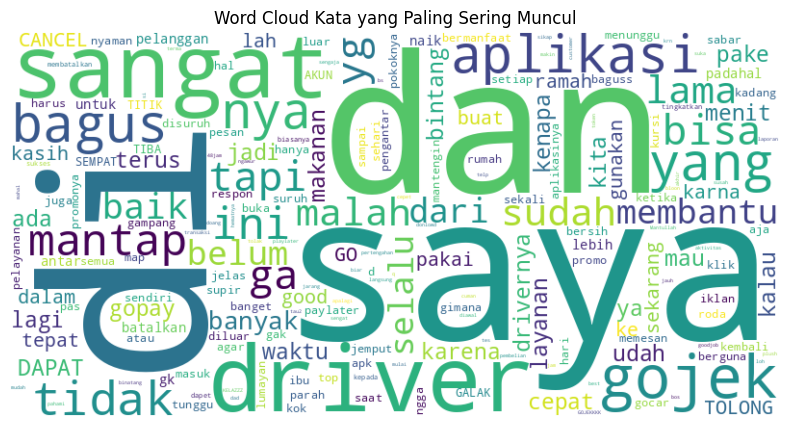

In [6]:
if not df.empty:
    # Pie Chart Distribusi Sentimen
    fig_pie = px.pie(df,
                     names='sentimen',
                     title='<b>Distribusi Sentimen Ulasan Pengguna</b>',
                     color_discrete_map={'Positif':'#2ca02c',
                                         'Negatif':'#d62728',
                                         'Campuran':'#ff7f0e',
                                         'Netral':'#1f77b4'})
    fig_pie.show()

    # Bar Chart Topik Keluhan Teratas (Negatif)
    negative_df = df[df['sentimen'] == 'Negatif']
    if not negative_df.empty:
        fig_bar_neg = px.bar(negative_df['topik'].value_counts().nlargest(10),
                             title='<b>Topik Keluhan Paling Umum</b>',
                             labels={'value':'Jumlah Ulasan', 'index':'Topik Keluhan'},
                             text_auto=True)
        fig_bar_neg.update_traces(marker_color='#d62728')
        fig_bar_neg.show()

    # Bar Chart Topik Pujian Teratas (Positif)
    positive_df = df[df['sentimen'] == 'Positif']
    if not positive_df.empty:
        fig_bar_pos = px.bar(positive_df['topik'].value_counts().nlargest(10),
                             title='<b>Topik Pujian Paling Umum</b>',
                             labels={'value':'Jumlah Ulasan', 'index':'Topik Pujian'},
                             text_auto=True)
        fig_bar_pos.update_traces(marker_color='#2ca02c')
        fig_bar_pos.show()

    # Word Cloud dari Semua Ulasan
    semua_ulasan_text = ' '.join(df['content'])

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis',
                          collocations=False).generate(semua_ulasan_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud Kata yang Paling Sering Muncul")
    plt.show()
else:
    print("DataFrame kosong, tidak ada data untuk divisualisasikan.")

In [7]:
if not df.empty:
    # --- Analisis untuk Insight ---
    sentiment_dist = df['sentimen'].value_counts(normalize=True) * 100
    top_positive_topic = df[df['sentimen'] == 'Positif']['topik'].mode()[0] if 'Positif' in df['sentimen'].values else "Tidak ada"
    top_complaint = df[df['sentimen'] == 'Negatif']['topik'].mode()[0] if 'Negatif' in df['sentimen'].values else "Tidak ada"

    print("===== Insight dan Temuan dari Analisis =====")

    print(f"\n📊 Gambaran Umum Sentimen:")
    print(f"Dari total {len(df)} ulasan yang valid, distribusi sentimen adalah: {', '.join([f'{k} ({v:.1f}%)' for k, v in sentiment_dist.items()])}.")

    print(f"\n👍 Pendorong Sentimen Positif:")
    print(f"Aspek yang paling dihargai pengguna dan menjadi kekuatan utama adalah '{top_positive_topic}'.")

    print(f"\n👎 Akar Masalah Ulasan Negatif:")
    print(f"Keluhan paling umum yang perlu menjadi prioritas perbaikan adalah seputar '{top_complaint}'.")

    print("\n💡 Rekomendasi Strategis:")
    print(f"  - PERKUAT: Pertahankan dan promosikan keunggulan pada '{top_positive_topic}'.")
    print(f"  - PERBAIKI: Fokuskan sumber daya untuk menyelesaikan masalah terkait '{top_complaint}' guna meningkatkan kepuasan pengguna.")
else:
    print("DataFrame kosong, tidak dapat menghasilkan insight.")

===== Insight dan Temuan dari Analisis =====

📊 Gambaran Umum Sentimen:
Dari total 88 ulasan yang valid, distribusi sentimen adalah: Positif (68.2%), Negatif (23.9%), Netral (8.0%).

👍 Pendorong Sentimen Positif:
Aspek yang paling dihargai pengguna dan menjadi kekuatan utama adalah 'Kualitas'.

👎 Akar Masalah Ulasan Negatif:
Keluhan paling umum yang perlu menjadi prioritas perbaikan adalah seputar 'Fitur upload foto'.

💡 Rekomendasi Strategis:
  - PERKUAT: Pertahankan dan promosikan keunggulan pada 'Kualitas'.
  - PERBAIKI: Fokuskan sumber daya untuk menyelesaikan masalah terkait 'Fitur upload foto' guna meningkatkan kepuasan pengguna.
